In [163]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay  

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.optimizers import SGD
from keras.layers import Dense, Flatten, BatchNormalization

In [2]:
bsc_path = 'Datasets'
img_path = os.path.join(bsc_path, 'images')
feature_path = os.path.join(bsc_path, 'gender_classification.csv')

In [3]:
number_images = len(os.listdir(img_path))
print('Total Images', number_images)

Total Images 10000


In [4]:
# Read the attributes csv files in a dataframe format.
df = pd.read_csv(feature_path)
df.columns = ["image_id", "Gender"]
df.head()

,image_id,Gender
0,000041.jpg,1
1,000044.jpg,0
2,000047.jpg,0
3,000050.jpg,1
4,000063.jpg,0


# Exploratory Data Analysis

## Sample Image

<text>Melihat beberapa image yang ada pada dataset yang akan digunakan untuk membuat model</text>

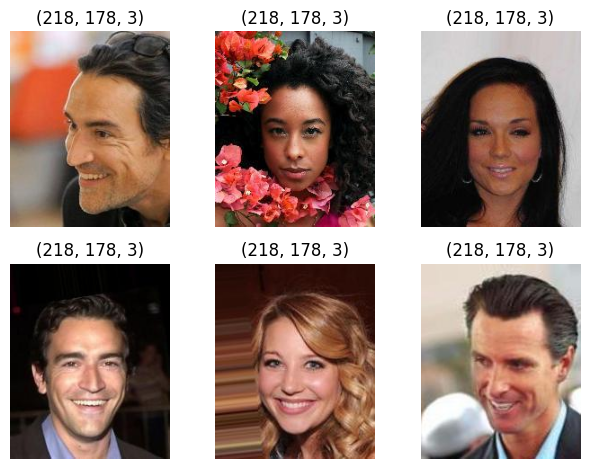

In [5]:
# Display Multiple Sample Images.
for i in range(0, 6):
    plt.subplot(2, 3, i+1)
    
    # Read an Image.
    img = cv2.imread(img_path + '/' + df["image_id"][i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Display Image.
    plt.imshow(img)
    plt.title(img.shape)
    plt.axis('off')
    
plt.tight_layout()
plt.show()

## Category Distribution

<text>Melihat distribusi dari category gender </text>

In [6]:
category_count = df["Gender"].value_counts()
print(category_count)

higher_category = list(category_count.index)[0]

0    5861
1    4139
Name: Gender, dtype: int64


<text>0 = Female (Perempuan),
1 = Male (Laki-laki)</text>

## Image Pixel Distribution

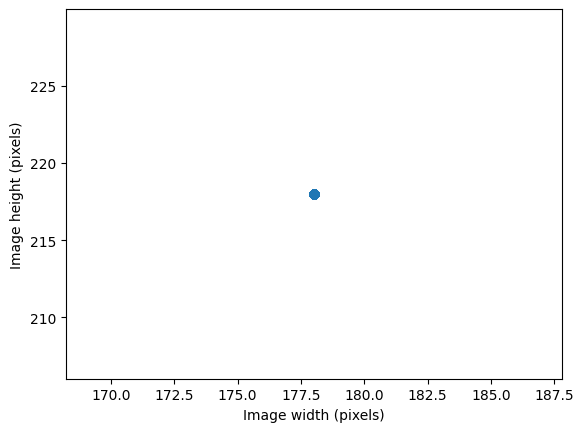

In [7]:
data_dir = 'Datasets/images'
image_sizes = []

for filename in os.listdir(data_dir):
    if filename.endswith('.jpg'):
        img_path = os.path.join(data_dir, filename)
        img = Image.open(img_path)
        width, height = img.size
        image_sizes.append((width, height))

# Create scatter plot of image sizes
x = [size[0] for size in image_sizes]
y = [size[1] for size in image_sizes]
plt.scatter(x, y)
plt.xlabel('Image width (pixels)')
plt.ylabel('Image height (pixels)')
plt.show()

<text>Dari sini dapat diambil kesimpulan bahwa semua data images berukuran 218 x 178 pixel</text>

# Data Preprocessing

## Drop Imbalance 

In [8]:
# Get the indices of the higher category indices images.
np.random.seed(42)
indices = df[df["Gender"] == higher_category].index
sample_size = category_count[0] - category_count[1]

# Drop the extra rows of images to fix class imbalance problem.
drop_sample = np.random.choice(indices, sample_size, replace = False)
df = df.drop(drop_sample, axis = "index")

<Axes: >

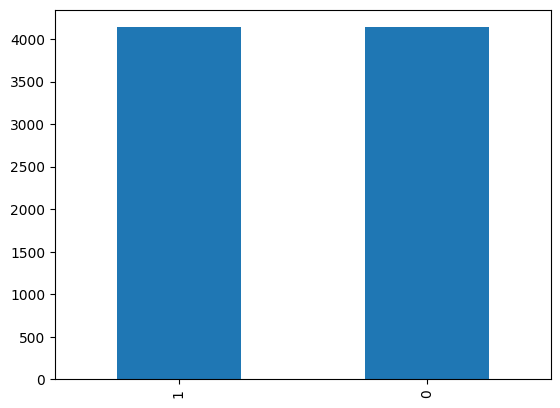

In [9]:
df["Gender"].value_counts().plot.bar()

<text>Berhasil menyeimbangkan data label 0 menyesuaikan dengan label 1 berjumlah 4139 setiap label nya</text>

## Change Value To String

In [10]:
df["Gender"] = df["Gender"].map({0: "0", 1: "1"})

In [11]:
df.head()

,image_id,Gender
0,000041.jpg,1
1,000044.jpg,0
2,000047.jpg,0
3,000050.jpg,1
4,000063.jpg,0


## Train Test Split

1. Data akan dibagi menjadi beberapa ukuran training dan test size = 80:20, 70:30, 60:40
2. Diubah ukuran image nya menjadi 224 x 224


In [12]:
train_df_80_20, test_df_80_20 = train_test_split(df, test_size=0.2)
train_df_70_30, test_df_70_30 = train_test_split(df, test_size=0.3)
train_df_60_40, test_df_60_40 = train_test_split(df, test_size=0.4)

In [13]:
print("Total Train Sample Images 80:20 : ", len(train_df_80_20))
print("Total Test Sample Images 80:20 : ", len(test_df_80_20))
print('\n')
print("Total Train Sample Images 70:30 : ", len(train_df_70_30))
print("Total Test Sample Images 70:30 : ", len(test_df_70_30))
print('\n')
print("Total Train Sample Images 60:40 : ", len(train_df_60_40))
print("Total Test Sample Images 60:40 : ", len(test_df_60_40))

Total Train Sample Images 80:20 :  6622
Total Test Sample Images 80:20 :  1656


Total Train Sample Images 70:30 :  5794
Total Test Sample Images 70:30 :  2484


Total Train Sample Images 60:40 :  4966
Total Test Sample Images 60:40 :  3312


## Create Image Data Generator for train and test data

In [14]:
df["image_exists"] = df["image_id"].apply(lambda x: os.path.exists(os.path.join(data_dir, x)))

In [15]:
df = df[df["image_exists"]]
df

,image_id,Gender,image_exists
0,000041.jpg,1,True
1,000044.jpg,0,True
2,000047.jpg,0,True
3,000050.jpg,1,True
4,000063.jpg,0,True
...,...,...,...
9995,202548.jpg,0,True
9996,202554.jpg,1,True
9997,202557.jpg,0,True
9998,202566.jpg,1,True


In [16]:
train_datagen = ImageDataGenerator(
    rotation_range= 15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    height_shift_range=0.1,
    width_shift_range=0.1
)
test_gen = ImageDataGenerator(rescale=1./255)

### Train Test 80:20

In [17]:
train_generator_80_20 = train_datagen.flow_from_dataframe(
    train_df_80_20, 
    data_dir, 
    x_col='image_id',
    y_col='Gender',
    target_size=(224,224),
    class_mode='binary'
    )
test_generator_80_20 = test_gen.flow_from_dataframe(
    test_df_80_20, 
    data_dir,  
    x_col='image_id',
    y_col='Gender',
    class_mode='binary',
    target_size=(224,224),
    shuffle=False
)

Found 6622 validated image filenames belonging to 2 classes.
Found 1656 validated image filenames belonging to 2 classes.


### Train Test 70:30

In [18]:
train_generator_70_30 = train_datagen.flow_from_dataframe(
    train_df_70_30, 
    data_dir, 
    x_col='image_id',
    y_col='Gender',
    target_size=(224,224),
    class_mode='binary'
    )
test_generator_70_30 = test_gen.flow_from_dataframe(
    test_df_70_30, 
    data_dir,  
    x_col='image_id',
    y_col='Gender',
    class_mode='binary',
    target_size=(224,224),
    shuffle=False
)

Found 5794 validated image filenames belonging to 2 classes.
Found 2484 validated image filenames belonging to 2 classes.


### Train Test 60:40

In [19]:
train_generator_60_40 = train_datagen.flow_from_dataframe(
    train_df_60_40, 
    data_dir, 
    x_col='image_id',
    y_col='Gender',
    target_size=(224,224),
    class_mode='binary'
    )
test_generator_60_40 = test_gen.flow_from_dataframe(
    test_df_60_40, 
    data_dir,  
    x_col='image_id',
    y_col='Gender',
    class_mode='binary',
    target_size=(224,224),
    shuffle=False
)

Found 4966 validated image filenames belonging to 2 classes.
Found 3312 validated image filenames belonging to 2 classes.


# Modelling

## Modelling 80:20

In [169]:
resnet_model_80_20_lr0001 = Sequential()

resnet_model_80_20_lr0001.add(tf.keras.applications.ResNet50(include_top=False, pooling='avg', weights='imagenet', input_shape=(224, 224, 3)))
resnet_model_80_20_lr0001.add(Flatten())
resnet_model_80_20_lr0001.add(BatchNormalization())
resnet_model_80_20_lr0001.add(Dense(2048, activation='relu'))
resnet_model_80_20_lr0001.add(BatchNormalization())
resnet_model_80_20_lr0001.add(Dense(1024, activation='relu'))
resnet_model_80_20_lr0001.add(BatchNormalization())
resnet_model_80_20_lr0001.add(Dense(2, activation='sigmoid'))

resnet_model_80_20_lr0001.layers[0].trainable = False

In [170]:
resnet_model_80_20_lr0001.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_4 (Flatten)         (None, 2048)              0         
                                                                 
 batch_normalization_3 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 dense_23 (Dense)            (None, 2048)              4196352   
                                                                 
 batch_normalization_4 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 dense_24 (Dense)            (None, 1024)            

#### Learning Rate 0.001

In [171]:
learning_rate = 0.001
optimizer=SGD(learning_rate=learning_rate)
resnet_model_80_20_lr0001.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [172]:
from keras.callbacks import EarlyStopping
earlystop = EarlyStopping(monitor = 'val_loss', patience=3)
callbacks = [earlystop]

In [173]:
history = resnet_model_80_20_lr0001.fit(train_generator_80_20, validation_data = test_generator_80_20,
                        epochs=5, verbose = 1, callbacks=callbacks)

Epoch 1/5
207/207 [==============================] - 62s 287ms/step - loss: 0.6903 - accuracy: 0.6531 - val_loss: 0.6670 - val_accuracy: 0.6081
Epoch 2/5
207/207 [==============================] - 59s 287ms/step - loss: 0.5943 - accuracy: 0.7046 - val_loss: 0.5656 - val_accuracy: 0.6800
Epoch 3/5
207/207 [==============================] - 57s 275ms/step - loss: 0.5617 - accuracy: 0.7215 - val_loss: 0.4651 - val_accuracy: 0.7880
Epoch 4/5
207/207 [==============================] - 57s 273ms/step - loss: 0.5477 - accuracy: 0.7321 - val_loss: 0.4655 - val_accuracy: 0.7911
Epoch 5/5
207/207 [==============================] - 59s 284ms/step - loss: 0.5348 - accuracy: 0.7413 - val_loss: 0.4637 - val_accuracy: 0.7947


Text(0.5, 1.0, 'Loss evolution')

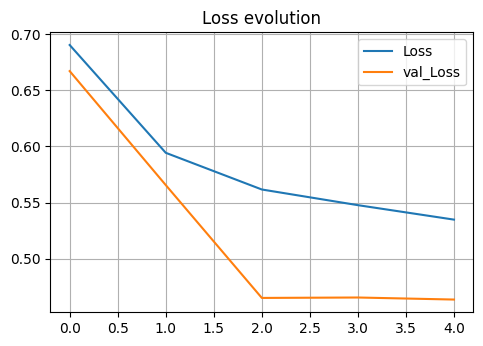

In [174]:
# Plot hasil loss dan val_loss
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='val_Loss')
plt.legend()
plt.grid()
plt.title('Loss evolution')

Text(0.5, 1.0, 'Accuracy')

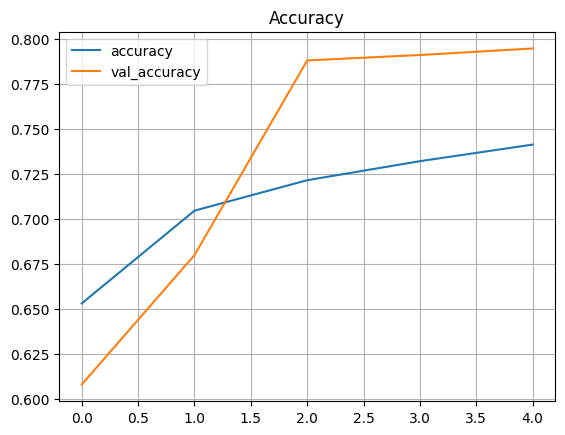

In [175]:
# Plot hasil accuracy dan val_accuracy
plt.subplot(1,1,1)
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.legend()
plt.grid()
plt.title('Accuracy')

In [176]:
resnet_model_80_20_lr0001.evaluate(test_generator_80_20)

52/52 [==============================] - 5s 86ms/step - loss: 0.4637 - accuracy: 0.7947


[0.4637034237384796, 0.7946860194206238]

In [177]:
predict = resnet_model_80_20_lr0001.predict(test_generator_80_20)

52/52 [==============================] - 5s 84ms/step


In [178]:
prediction = predict.argmax(axis=-1)
test_df_80_20['Prediction'] = ["1" if ele == 1 else "0" for ele in prediction]

In [179]:
test_df_80_20

,image_id,Gender,Prediction
3196,064728.jpg,0,0
6245,127265.jpg,0,0
7809,158690.jpg,1,1
650,013246.jpg,0,0
4461,089831.jpg,0,0
...,...,...,...
7529,152582.jpg,1,1
5521,112046.jpg,1,1
4159,084460.jpg,0,0
4679,094792.jpg,1,1


In [180]:
labels = ['1','0']

cm = confusion_matrix(test_df_80_20['Gender'], test_df_80_20["Prediction"], labels= labels)
cm

array([[673, 134],
       [206, 643]], dtype=int64)

In [181]:
y_pred = resnet_model_80_20_lr0001.predict(test_generator_80_20)

52/52 [==============================] - 4s 83ms/step


In [182]:
predicted_classes = np.argmax(y_pred, axis=1)

In [183]:
true_classes = test_generator_80_20.classes

In [184]:
class_labels = list(test_generator_80_20.class_indices.keys())

In [185]:
from sklearn.metrics import classification_report

report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

           0       0.83      0.76      0.79       849
           1       0.77      0.83      0.80       807

    accuracy                           0.79      1656
   macro avg       0.80      0.80      0.79      1656
weighted avg       0.80      0.79      0.79      1656



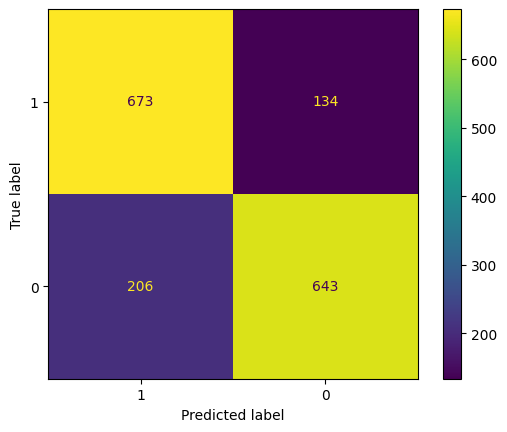

In [186]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
disp.plot()
plt.show()

#### Learning Rate 0.01

In [188]:
resnet_model_80_20_lr001 = Sequential()

resnet_model_80_20_lr001.add(tf.keras.applications.ResNet50(include_top=False, pooling='avg', weights='imagenet', input_shape=(224, 224, 3)))
resnet_model_80_20_lr001.add(Flatten())
resnet_model_80_20_lr001.add(BatchNormalization())
resnet_model_80_20_lr001.add(Dense(2048, activation='relu'))
resnet_model_80_20_lr001.add(BatchNormalization())
resnet_model_80_20_lr001.add(Dense(1024, activation='relu'))
resnet_model_80_20_lr001.add(BatchNormalization())
resnet_model_80_20_lr001.add(Dense(2, activation='sigmoid'))

resnet_model_80_20_lr001.layers[0].trainable = False
resnet_model_80_20_lr001.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_6 (Flatten)         (None, 2048)              0         
                                                                 
 batch_normalization_9 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 dense_29 (Dense)            (None, 2048)              4196352   
                                                                 
 batch_normalization_10 (Bat  (None, 2048)             8192      
 chNormalization)                                                
                                                                 
 dense_30 (Dense)            (None, 1024)            

In [189]:
learning_rate = 0.01
optimizer=SGD(learning_rate=learning_rate)
resnet_model_80_20_lr001.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [190]:
from keras.callbacks import EarlyStopping
earlystop = EarlyStopping(monitor = 'val_loss', patience=3)
callbacks = [earlystop]

In [191]:
history = resnet_model_80_20_lr001.fit(train_generator_80_20, validation_data = test_generator_80_20,
                                epochs=5, verbose = 1, callbacks=callbacks)

Epoch 1/5
207/207 [==============================] - 62s 284ms/step - loss: 0.7287 - accuracy: 0.6770 - val_loss: 0.6423 - val_accuracy: 0.7222
Epoch 2/5
207/207 [==============================] - 59s 283ms/step - loss: 0.5757 - accuracy: 0.7244 - val_loss: 0.5420 - val_accuracy: 0.7313
Epoch 3/5
207/207 [==============================] - 60s 289ms/step - loss: 0.5506 - accuracy: 0.7418 - val_loss: 0.4626 - val_accuracy: 0.7947
Epoch 4/5
207/207 [==============================] - 62s 301ms/step - loss: 0.5311 - accuracy: 0.7412 - val_loss: 0.4500 - val_accuracy: 0.8037
Epoch 5/5
207/207 [==============================] - 62s 301ms/step - loss: 0.5062 - accuracy: 0.7510 - val_loss: 0.4571 - val_accuracy: 0.7953


Text(0.5, 1.0, 'Loss evolution')

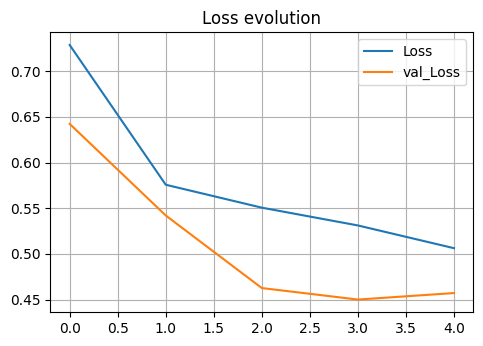

In [192]:
# Plot hasil loss dan val_loss
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='val_Loss')
plt.legend()
plt.grid()
plt.title('Loss evolution')

Text(0.5, 1.0, 'Accuracy')

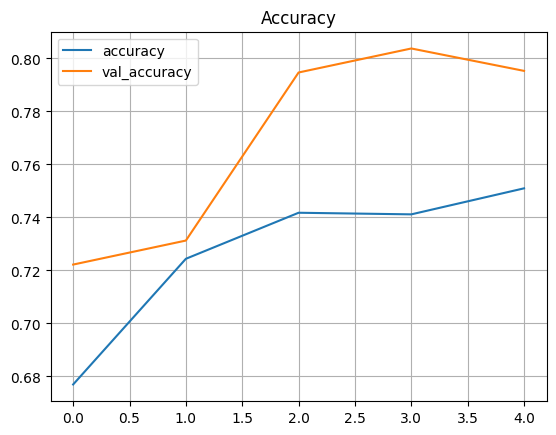

In [193]:
# Plot hasil accuracy dan val_accuracy
plt.subplot(1,1,1)
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.legend()
plt.grid()
plt.title('Accuracy')

In [194]:
resnet_model_80_20_lr001.evaluate(test_generator_80_20)

52/52 [==============================] - 5s 87ms/step - loss: 0.4571 - accuracy: 0.7953


[0.4570773243904114, 0.7952898740768433]

In [195]:
predict = resnet_model_80_20_lr001.predict(test_generator_80_20)

52/52 [==============================] - 5s 89ms/step


In [196]:
prediction = predict.argmax(axis=-1)
test_df_80_20['Prediction'] = ["1" if ele == 1 else "0" for ele in prediction]
test_df_80_20

,image_id,Gender,Prediction
3196,064728.jpg,0,0
6245,127265.jpg,0,1
7809,158690.jpg,1,1
650,013246.jpg,0,1
4461,089831.jpg,0,1
...,...,...,...
7529,152582.jpg,1,1
5521,112046.jpg,1,1
4159,084460.jpg,0,0
4679,094792.jpg,1,1


In [197]:
labels = ['1','0']

cm = confusion_matrix(test_df_80_20['Gender'], test_df_80_20["Prediction"], labels= labels)
cm

array([[687, 120],
       [219, 630]], dtype=int64)

In [198]:
from sklearn.metrics import classification_report

true_classes = test_generator_80_20.classes

report = classification_report(true_classes, prediction, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

           0       0.84      0.74      0.79       849
           1       0.76      0.85      0.80       807

    accuracy                           0.80      1656
   macro avg       0.80      0.80      0.80      1656
weighted avg       0.80      0.80      0.79      1656



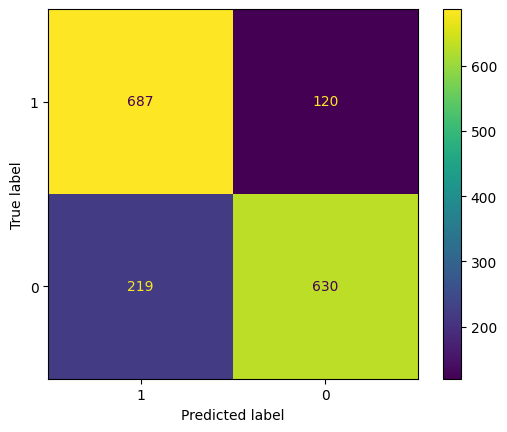

In [199]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
disp.plot()
plt.show()

#### Learning Rate 0.1

In [200]:
resnet_model_80_20_lr01 = Sequential()

resnet_model_80_20_lr01.add(tf.keras.applications.ResNet50(include_top=False, pooling='avg', weights='imagenet', input_shape=(224, 224, 3)))
resnet_model_80_20_lr01.add(Flatten())
resnet_model_80_20_lr01.add(BatchNormalization())
resnet_model_80_20_lr01.add(Dense(2048, activation='relu'))
resnet_model_80_20_lr01.add(BatchNormalization())
resnet_model_80_20_lr01.add(Dense(1024, activation='relu'))
resnet_model_80_20_lr01.add(BatchNormalization())
resnet_model_80_20_lr01.add(Dense(2, activation='sigmoid'))

resnet_model_80_20_lr01.layers[0].trainable = False
resnet_model_80_20_lr01.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_7 (Flatten)         (None, 2048)              0         
                                                                 
 batch_normalization_12 (Bat  (None, 2048)             8192      
 chNormalization)                                                
                                                                 
 dense_32 (Dense)            (None, 2048)              4196352   
                                                                 
 batch_normalization_13 (Bat  (None, 2048)             8192      
 chNormalization)                                                
                                                                 
 dense_33 (Dense)            (None, 1024)            

In [201]:
learning_rate = 0.1
optimizer=SGD(learning_rate=learning_rate)
resnet_model_80_20_lr01.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [202]:
from keras.callbacks import EarlyStopping
earlystop = EarlyStopping(monitor = 'val_loss', patience=3)
callbacks = [earlystop]

In [203]:
history = resnet_model_80_20_lr01.fit(train_generator_80_20, validation_data = test_generator_80_20,
                                epochs=5, verbose = 1, callbacks=callbacks)

Epoch 1/5
207/207 [==============================] - 64s 298ms/step - loss: 2.3020 - accuracy: 0.5986 - val_loss: 1.4314 - val_accuracy: 0.4861
Epoch 2/5
207/207 [==============================] - 59s 286ms/step - loss: 1.5147 - accuracy: 0.6392 - val_loss: 1.6110 - val_accuracy: 0.4752
Epoch 3/5
207/207 [==============================] - 60s 292ms/step - loss: 1.3304 - accuracy: 0.6551 - val_loss: 1.7798 - val_accuracy: 0.6800
Epoch 4/5
207/207 [==============================] - 60s 291ms/step - loss: 1.1580 - accuracy: 0.6756 - val_loss: 0.9791 - val_accuracy: 0.7772
Epoch 5/5
207/207 [==============================] - 60s 291ms/step - loss: 1.0058 - accuracy: 0.6919 - val_loss: 1.0465 - val_accuracy: 0.7367


Text(0.5, 1.0, 'Loss evolution')

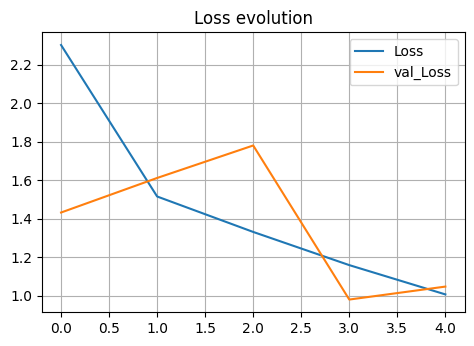

In [204]:
# Plot hasil loss dan val_loss
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='val_Loss')
plt.legend()
plt.grid()
plt.title('Loss evolution')

Text(0.5, 1.0, 'Accuracy')

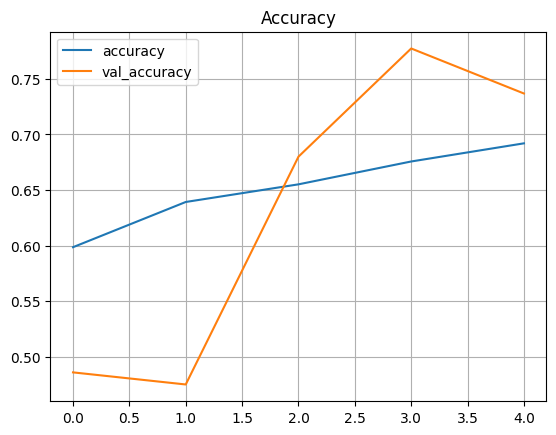

In [205]:
# Plot hasil accuracy dan val_accuracy
plt.subplot(1,1,1)
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.legend()
plt.grid()
plt.title('Accuracy')

In [206]:
results = resnet_model_80_20_lr01.evaluate(test_generator_80_20)
accuracy = results[1]

52/52 [==============================] - 4s 82ms/step - loss: 1.0465 - accuracy: 0.7367


In [207]:
predict = resnet_model_80_20_lr01.predict(test_generator_80_20)

52/52 [==============================] - 5s 83ms/step


In [208]:
prediction = predict.argmax(axis=-1)
test_df_80_20['Prediction'] = ["1" if ele == 1 else "0" for ele in prediction]
test_df_80_20

,image_id,Gender,Prediction
3196,064728.jpg,0,0
6245,127265.jpg,0,1
7809,158690.jpg,1,1
650,013246.jpg,0,0
4461,089831.jpg,0,0
...,...,...,...
7529,152582.jpg,1,1
5521,112046.jpg,1,1
4159,084460.jpg,0,0
4679,094792.jpg,1,1


In [209]:
labels = ['1','0']

cm = confusion_matrix(test_df_80_20['Gender'], test_df_80_20["Prediction"], labels= labels)
cm

array([[676, 131],
       [305, 544]], dtype=int64)

In [210]:
from sklearn.metrics import classification_report
true_classes = test_generator_80_20.classes
report = classification_report(true_classes, prediction, target_names=labels)
print(report)

              precision    recall  f1-score   support

           1       0.81      0.64      0.71       849
           0       0.69      0.84      0.76       807

    accuracy                           0.74      1656
   macro avg       0.75      0.74      0.74      1656
weighted avg       0.75      0.74      0.73      1656



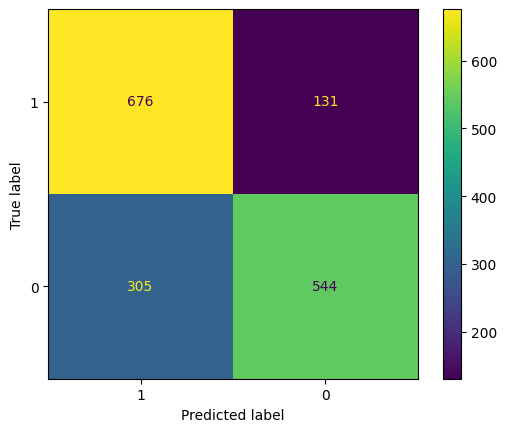

In [211]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
disp.plot()
plt.show()

#### Kesimpulan Learning Rate
* Penggunaan learning rate nilai 0.001 lebih optimal karena nilai loss nya lebih kecil dibandingkan dengan penggunaan learning rate 0.01, 0.1

## Modelling 80:20

In [216]:
resnet_model_80_20 = Sequential()

resnet_model_80_20.add(tf.keras.applications.ResNet50(include_top=False, pooling='avg', weights='imagenet', input_shape=(224, 224, 3)))
resnet_model_80_20.add(Flatten())
resnet_model_80_20.add(BatchNormalization())
resnet_model_80_20.add(Dense(2048, activation='relu'))
resnet_model_80_20.add(BatchNormalization())
resnet_model_80_20.add(Dense(1024, activation='relu'))
resnet_model_80_20.add(BatchNormalization())
resnet_model_80_20.add(Dense(2, activation='sigmoid'))

resnet_model_80_20.layers[0].trainable = False
resnet_model_80_20.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_9 (Flatten)         (None, 2048)              0         
                                                                 
 batch_normalization_18 (Bat  (None, 2048)             8192      
 chNormalization)                                                
                                                                 
 dense_38 (Dense)            (None, 2048)              4196352   
                                                                 
 batch_normalization_19 (Bat  (None, 2048)             8192      
 chNormalization)                                                
                                                                 
 dense_39 (Dense)            (None, 1024)            

In [217]:
learning_rate = 0.001
optimizer=SGD(learning_rate=learning_rate)
resnet_model_80_20.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [218]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
checkpoint = ModelCheckpoint(os.path.join(bsc_path, 'gender_classification_model_resnet_82.h5'), monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
earlystop = EarlyStopping(monitor = 'val_loss', patience=5)
callbacks = [earlystop, checkpoint]

In [219]:
history = resnet_model_80_20.fit(train_generator_80_20, validation_data = test_generator_80_20, epochs=20, verbose = 1, batch_size = 16, callbacks=callbacks)

Epoch 1/20
207/207 [==============================] - ETA: 0s - loss: 0.7109 - accuracy: 0.6413
Epoch 1: val_accuracy improved from -inf to 0.48732, saving model to Datasets\gender_classification_model_resnet_82.h5
207/207 [==============================] - 64s 296ms/step - loss: 0.7109 - accuracy: 0.6413 - val_loss: 0.8830 - val_accuracy: 0.4873
Epoch 2/20
207/207 [==============================] - ETA: 0s - loss: 0.6109 - accuracy: 0.6937
Epoch 2: val_accuracy improved from 0.48732 to 0.71558, saving model to Datasets\gender_classification_model_resnet_82.h5
207/207 [==============================] - 59s 283ms/step - loss: 0.6109 - accuracy: 0.6937 - val_loss: 0.5675 - val_accuracy: 0.7156
Epoch 3/20
207/207 [==============================] - ETA: 0s - loss: 0.5643 - accuracy: 0.7273
Epoch 3: val_accuracy improved from 0.71558 to 0.75966, saving model to Datasets\gender_classification_model_resnet_82.h5
207/207 [==============================] - 60s 292ms/step - loss: 0.5643 - accura

Text(0.5, 1.0, 'Loss evolution')

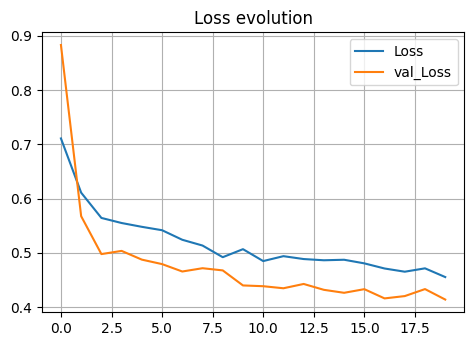

In [220]:
# Plot hasil loss dan val_loss
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='val_Loss')
plt.legend()
plt.grid()
plt.title('Loss evolution')

Text(0.5, 1.0, 'Accuracy')

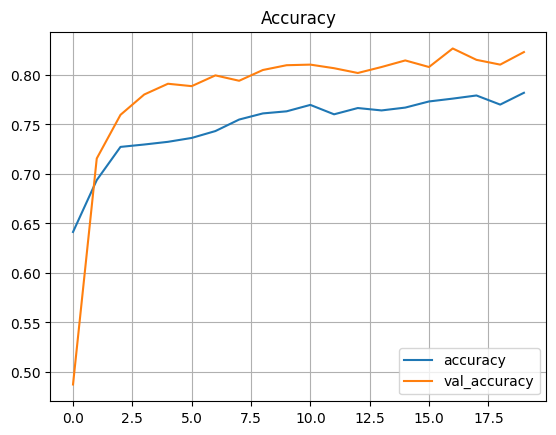

In [221]:
# Plot hasil accuracy dan val_accuracy
plt.subplot(1,1,1)
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.legend()
plt.grid()
plt.title('Accuracy')

In [222]:
results = resnet_model_80_20.evaluate(test_generator_80_20)
accuracy = results[1]

52/52 [==============================] - 5s 82ms/step - loss: 0.4139 - accuracy: 0.8231


In [223]:
predict = resnet_model_80_20.predict(test_generator_80_20)

52/52 [==============================] - 5s 87ms/step


In [224]:
prediction = predict.argmax(axis=-1)
test_df_80_20['Prediction'] = ["1" if ele == 1 else "0" for ele in prediction]
test_df_80_20

,image_id,Gender,Prediction
3196,064728.jpg,0,0
6245,127265.jpg,0,0
7809,158690.jpg,1,1
650,013246.jpg,0,1
4461,089831.jpg,0,1
...,...,...,...
7529,152582.jpg,1,1
5521,112046.jpg,1,1
4159,084460.jpg,0,0
4679,094792.jpg,1,1


In [225]:
labels = ['1','0']

cm = confusion_matrix(test_df_80_20['Gender'], test_df_80_20["Prediction"], labels= labels)
cm

array([[683, 124],
       [169, 680]], dtype=int64)

In [226]:
from sklearn.metrics import classification_report
true_classes = test_generator_80_20.classes
report = classification_report(true_classes, prediction, target_names=labels)
print(report)

              precision    recall  f1-score   support

           1       0.85      0.80      0.82       849
           0       0.80      0.85      0.82       807

    accuracy                           0.82      1656
   macro avg       0.82      0.82      0.82      1656
weighted avg       0.82      0.82      0.82      1656



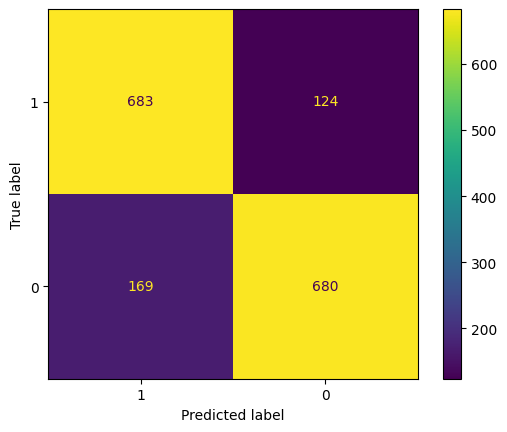

In [227]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
disp.plot()
plt.show()

## Modelling 70:30

In [233]:
resnet_model_70_30 = Sequential()

resnet_model_70_30.add(tf.keras.applications.ResNet50(include_top=False, pooling='avg', weights='imagenet', input_shape=(224, 224, 3)))
resnet_model_70_30.add(Flatten())
resnet_model_70_30.add(BatchNormalization())
resnet_model_70_30.add(Dense(2048, activation='relu'))
resnet_model_70_30.add(BatchNormalization())
resnet_model_70_30.add(Dense(1024, activation='relu'))
resnet_model_70_30.add(BatchNormalization())
resnet_model_70_30.add(Dense(2, activation='sigmoid'))

resnet_model_70_30.layers[0].trainable = False
resnet_model_70_30.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_11 (Flatten)        (None, 2048)              0         
                                                                 
 batch_normalization_24 (Bat  (None, 2048)             8192      
 chNormalization)                                                
                                                                 
 dense_44 (Dense)            (None, 2048)              4196352   
                                                                 
 batch_normalization_25 (Bat  (None, 2048)             8192      
 chNormalization)                                                
                                                                 
 dense_45 (Dense)            (None, 1024)            

In [234]:
learning_rate = 0.001
optimizer=SGD(learning_rate=learning_rate)
resnet_model_70_30.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [235]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
checkpoint = ModelCheckpoint(os.path.join(bsc_path, 'gender_classification_model_resnet_73.h5'), monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
earlystop = EarlyStopping(monitor = 'val_loss', patience=3)
callbacks = [earlystop, checkpoint]

In [236]:
history = resnet_model_70_30.fit(train_generator_70_30, validation_data = test_generator_70_30, epochs=20, verbose = 1, batch_size = 16, callbacks=callbacks)

Epoch 1/20
182/182 [==============================] - ETA: 0s - loss: 0.6948 - accuracy: 0.6422
Epoch 1: val_accuracy improved from -inf to 0.53261, saving model to Datasets\gender_classification_model_resnet_73.h5
182/182 [==============================] - 61s 320ms/step - loss: 0.6948 - accuracy: 0.6422 - val_loss: 0.6775 - val_accuracy: 0.5326
Epoch 2/20
182/182 [==============================] - ETA: 0s - loss: 0.6097 - accuracy: 0.6938
Epoch 2: val_accuracy improved from 0.53261 to 0.69444, saving model to Datasets\gender_classification_model_resnet_73.h5
182/182 [==============================] - 55s 299ms/step - loss: 0.6097 - accuracy: 0.6938 - val_loss: 0.5937 - val_accuracy: 0.6944
Epoch 3/20
182/182 [==============================] - ETA: 0s - loss: 0.5752 - accuracy: 0.7201
Epoch 3: val_accuracy improved from 0.69444 to 0.74275, saving model to Datasets\gender_classification_model_resnet_73.h5
182/182 [==============================] - 53s 292ms/step - loss: 0.5752 - accura

In [237]:
results = resnet_model_70_30.evaluate(test_generator_70_30)
accuracy = results[1]

78/78 [==============================] - 7s 82ms/step - loss: 0.4727 - accuracy: 0.7878


In [238]:
predict = resnet_model_70_30.predict(test_generator_70_30)

78/78 [==============================] - 7s 84ms/step


In [239]:
prediction = predict.argmax(axis=-1)
test_df_70_30['Prediction'] = ["1" if ele == 1 else "0" for ele in prediction]
test_df_70_30

,image_id,Gender,Prediction
1662,033417.jpg,1,1
8733,177330.jpg,1,1
9295,188623.jpg,0,0
5592,113713.jpg,0,0
1829,036818.jpg,0,0
...,...,...,...
1435,029101.jpg,0,0
7549,153031.jpg,0,0
8944,181185.jpg,0,0
7631,154824.jpg,0,0


In [240]:
labels = ['1','0']

cm = confusion_matrix(test_df_70_30['Gender'], test_df_70_30["Prediction"], labels= labels)
cm

array([[1074,  226],
       [ 301,  883]], dtype=int64)

In [241]:
from sklearn.metrics import classification_report
true_classes = test_generator_70_30.classes
report = classification_report(true_classes, prediction, target_names=labels)
print(report)

              precision    recall  f1-score   support

           1       0.80      0.75      0.77      1184
           0       0.78      0.83      0.80      1300

    accuracy                           0.79      2484
   macro avg       0.79      0.79      0.79      2484
weighted avg       0.79      0.79      0.79      2484



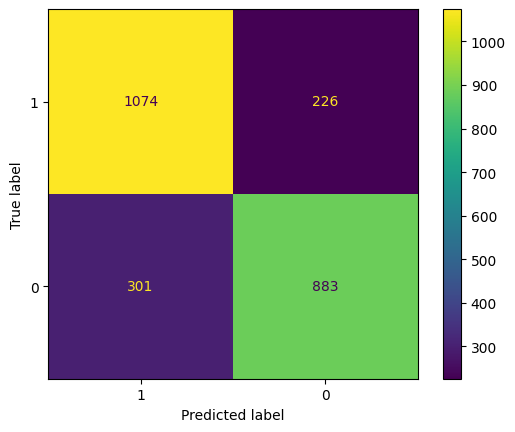

In [242]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
disp.plot()
plt.show()

## Modelling 60:40

In [243]:
resnet_model_60_40 = Sequential()

resnet_model_60_40.add(tf.keras.applications.ResNet50(include_top=False, pooling='avg', weights='imagenet', input_shape=(224, 224, 3)))
resnet_model_60_40.add(Flatten())
resnet_model_60_40.add(BatchNormalization())
resnet_model_60_40.add(Dense(2048, activation='relu'))
resnet_model_60_40.add(BatchNormalization())
resnet_model_60_40.add(Dense(1024, activation='relu'))
resnet_model_60_40.add(BatchNormalization())
resnet_model_60_40.add(Dense(2, activation='sigmoid'))

resnet_model_60_40.layers[0].trainable = False
resnet_model_60_40.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_12 (Flatten)        (None, 2048)              0         
                                                                 
 batch_normalization_27 (Bat  (None, 2048)             8192      
 chNormalization)                                                
                                                                 
 dense_47 (Dense)            (None, 2048)              4196352   
                                                                 
 batch_normalization_28 (Bat  (None, 2048)             8192      
 chNormalization)                                                
                                                                 
 dense_48 (Dense)            (None, 1024)            

In [244]:
learning_rate = 0.001
optimizer=SGD(learning_rate=learning_rate)
resnet_model_60_40.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [245]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
checkpoint = ModelCheckpoint(os.path.join(bsc_path, 'gender_classification_model_resnet_64.h5'), monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
earlystop = EarlyStopping(monitor = 'val_loss', patience=3)
callbacks = [earlystop, checkpoint]

In [246]:
history = resnet_model_60_40.fit(train_generator_60_40, validation_data = test_generator_60_40, epochs=20, verbose = 1, batch_size = 16, callbacks=callbacks)

Epoch 1/20
156/156 [==============================] - ETA: 0s - loss: 0.7005 - accuracy: 0.6460
Epoch 1: val_accuracy improved from -inf to 0.49306, saving model to Datasets\gender_classification_model_resnet_64.h5
156/156 [==============================] - 54s 329ms/step - loss: 0.7005 - accuracy: 0.6460 - val_loss: 0.7702 - val_accuracy: 0.4931
Epoch 2/20
156/156 [==============================] - ETA: 0s - loss: 0.6249 - accuracy: 0.6899
Epoch 2: val_accuracy improved from 0.49306 to 0.64432, saving model to Datasets\gender_classification_model_resnet_64.h5
156/156 [==============================] - 51s 326ms/step - loss: 0.6249 - accuracy: 0.6899 - val_loss: 0.6215 - val_accuracy: 0.6443
Epoch 3/20
156/156 [==============================] - ETA: 0s - loss: 0.5871 - accuracy: 0.7102
Epoch 3: val_accuracy improved from 0.64432 to 0.71830, saving model to Datasets\gender_classification_model_resnet_64.h5
156/156 [==============================] - 51s 327ms/step - loss: 0.5871 - accura

In [247]:
results = resnet_model_60_40.evaluate(test_generator_60_40)
accuracy = results[1]

104/104 [==============================] - 9s 82ms/step - loss: 0.4364 - accuracy: 0.8122


In [248]:
predict = resnet_model_60_40.predict(test_generator_60_40)

104/104 [==============================] - 9s 84ms/step


In [249]:
prediction = predict.argmax(axis=-1)
test_df_60_40['Prediction'] = ["1" if ele == 1 else "0" for ele in prediction]
test_df_60_40

,image_id,Gender,Prediction
6863,139583.jpg,0,0
945,018484.jpg,1,1
4267,086303.jpg,1,1
7964,161904.jpg,1,1
5554,112970.jpg,0,0
...,...,...,...
3982,080995.jpg,1,0
6547,133367.jpg,1,1
9566,194196.jpg,0,0
1059,020870.jpg,0,1


In [250]:
labels = ['1','0']

cm = confusion_matrix(test_df_60_40['Gender'], test_df_60_40["Prediction"], labels= labels)
cm

array([[1440,  239],
       [ 383, 1250]], dtype=int64)

In [251]:
from sklearn.metrics import classification_report
true_classes = test_generator_60_40.classes
report = classification_report(true_classes, prediction, target_names=labels)
print(report)

              precision    recall  f1-score   support

           1       0.84      0.77      0.80      1633
           0       0.79      0.86      0.82      1679

    accuracy                           0.81      3312
   macro avg       0.81      0.81      0.81      3312
weighted avg       0.81      0.81      0.81      3312



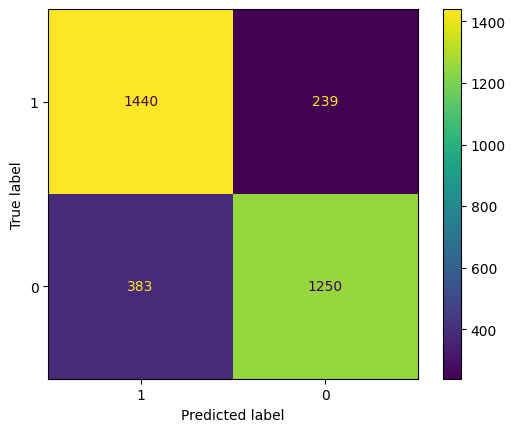

In [252]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
disp.plot()
plt.show()